#  Risk Score Regression Notebook
Based on the provided dataset, this framework visualizes a suitable polynomial regression curve for decaying an Indicator of Compromise (IoC) risk score.

In [1]:
# Package import
import numpy as np
import pandas as pd 
import json
import math 
from datetime import datetime
from datetime import timedelta
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
from msticpy.vis import mp_pandas_plot
from msticpy.vis.data_viewer import DataViewer

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Data Import
The calculation of an IoC lifetime relies on sightings or submissions, meaning that the indicator was seen by a security appliance or person, confirming that it is still active. The provided dataset should consist of indicators that have already expired and are relevant to the target to be protected. If the used threat intelligence does not provide an expiration attribute, an indicator can be seen as expired when it has had no sightings or submissions for a long time. The data should be provided as a CSV file with the individual sightings separated by a special character.

Example: 159.223.77.151;2022-11-29 02:24#2022-10-12 01:49#2022-03-04 05:28#2022-11-29 02:25#2022-10-12 01:49#2022-03-05 06:00

<span style="color:red">Please adapt the variables below and enter the path to the dataset.</span>

In [2]:
# Variables
dataSeparator = ","
sightingSeparator = "#"
pathDataset = ".\Data\\Phishing\VT_Submissions_Metadata.csv"

## Visualization of the Provided Data

In [3]:
customData = pd.read_csv(pathDataset, sep=dataSeparator, encoding='windows-1252')
# Separat sightings
customData["sightings"] = customData["sightings"].str.split(sightingSeparator)

# Remove all rows where the indicator is younger than 1 month
present = datetime.now()
past = timedelta(days=31)
year = present - past

customData["Last Submission"] = customData["Last Submission"].apply(lambda x: pd.to_datetime(x))
customData["First Submission"] = customData["First Submission"].apply(lambda x: pd.to_datetime(x))
customData["lifetimeHours"] = (customData["Last Submission"] - customData["First Submission"]) / pd.Timedelta(hours=1)
customData = customData[customData["Last Submission"] < year]
customData = customData[customData["Last Submission"] != customData["First Submission"]]
customData = customData[customData['lifetimeHours'] >= 0].dropna()
customData = customData[customData['Malicious'] != 0]

# Show Indicators
DataViewer(customData)

Column(sizing_mode='stretch_width')
    [0] Tabulator(header_filters=True, height=550, pagination='local', selectable='checkbox', show_index=False, sizing_mode='stretch_width', value=     Unnamed: 0           ...)
    [1] Accordion(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] MultiSelect(name='Select columns t..., options=['Unnamed: 0', ...], size=15, sizing_mode='stretch_width', value=['Indicator', ...])
            [1] Button(name='Apply columns', sizing_mode='stretch_width')

In [4]:
customData["lifetimeDays"] = customData["lifetimeHours"].apply(lambda x: math.ceil((x/24)))
customData["lifetimeWeeks"] = customData["lifetimeDays"].apply(lambda x: math.ceil((x/7)))

<Axes: xlabel='Lifetime in Full Weeks', ylabel='Count'>

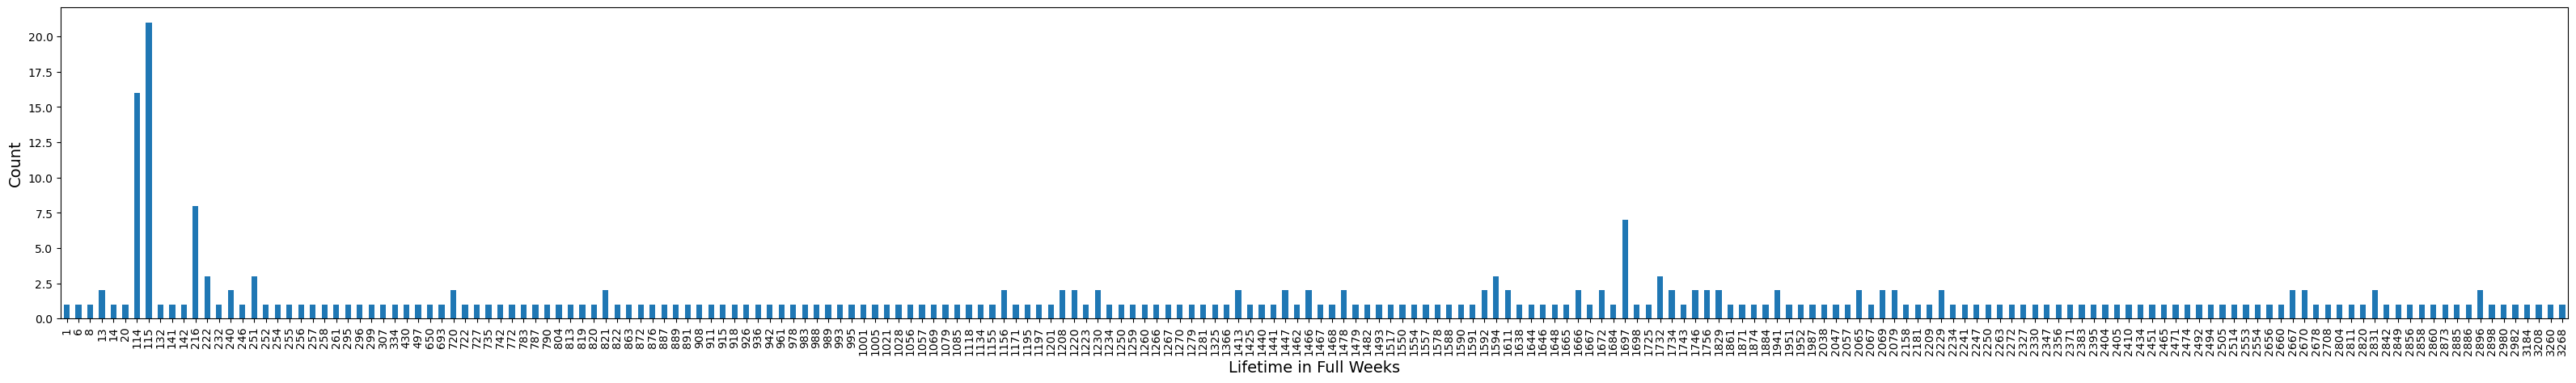

In [5]:
# Dispay as barplot
fig = plt.figure(figsize = (40, 5))
plt.xlabel("Lifetime in Full Weeks", fontsize=14)
plt.ylabel("Count", fontsize=14)
customData["lifetimeDays"].value_counts().sort_index().plot.bar()

<Axes: xlabel='Lifetime in Full Weeks', ylabel='Count'>

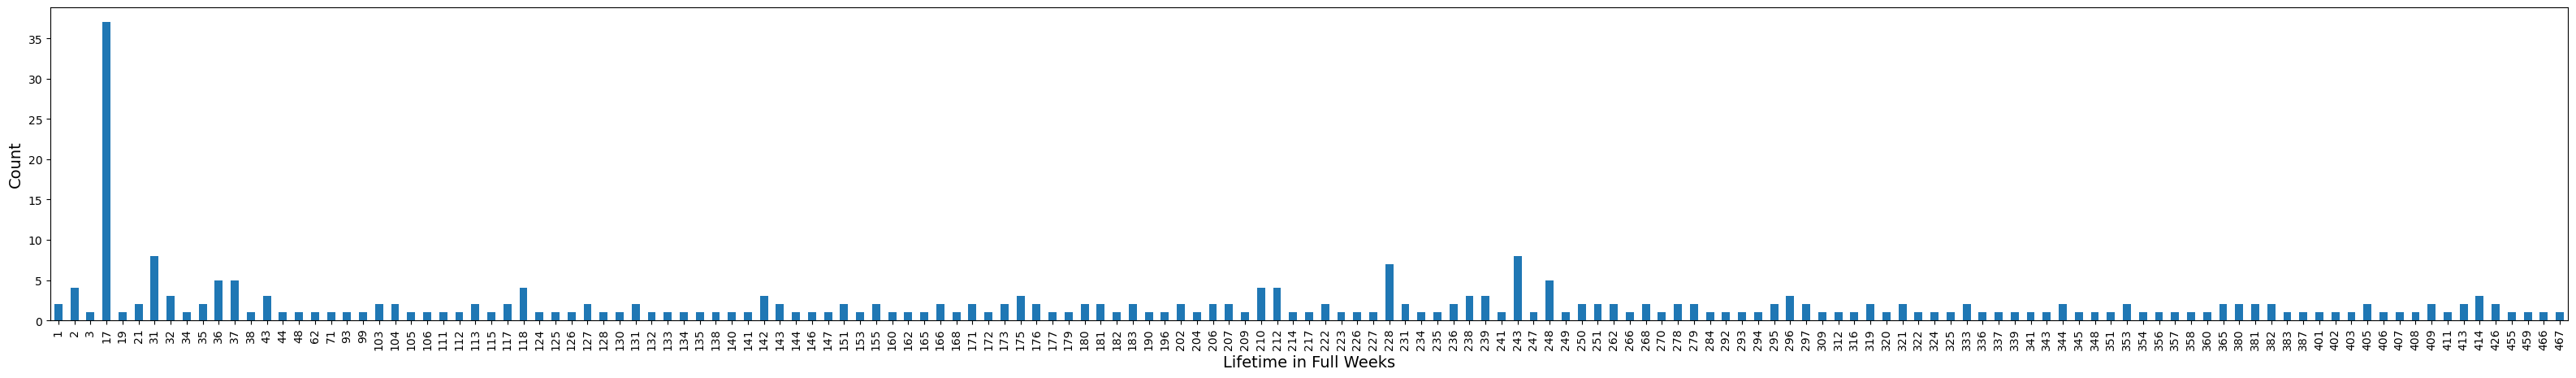

In [6]:
# Dispay as barplot
fig = plt.figure(figsize = (40, 5))
plt.xlabel("Lifetime in Full Weeks", fontsize=14)
plt.ylabel("Count", fontsize=14)
customData["lifetimeWeeks"].value_counts().sort_index().plot.bar()

<Axes: xlabel='lifetimeWeeks', ylabel='Count'>

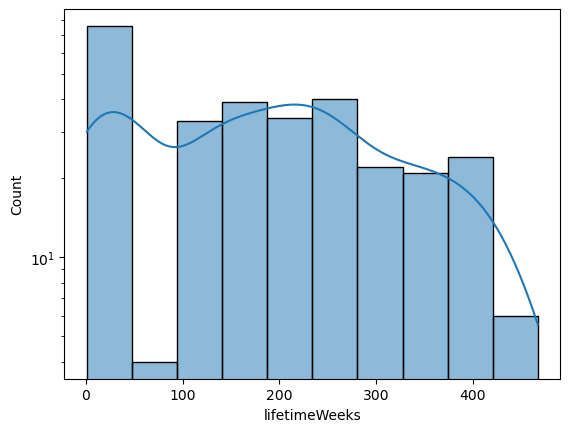

In [7]:
sns.histplot(customData["lifetimeWeeks"], kde=True, log=True)

In [8]:
# Fix timestamps
customData["sightings"] = customData["sightings"].apply(lambda x: pd.to_datetime(x))
customData["sightings"] = customData["sightings"].apply(sorted)

In [9]:
# Calculate timedelta between sightings
customData["timeBetweenSightings"] = customData["sightings"].apply(lambda x: [x[i]-x[i-1] if i > 0 and x[i]-x[i-1] > timedelta(seconds=0) else None for i in range(len(x))])
customData["timeBetweenSightings"] = customData["timeBetweenSightings"].apply(lambda L: [x for x in L if x is not None])
customData["timeBetweenSightingsHours"] = customData["timeBetweenSightings"].apply(lambda L: [str(timedelta(seconds = x.total_seconds())) for x in L])

In [10]:
timeBetweenSightingsList = customData['timeBetweenSightings'].values.tolist()
sightingsTimeline = []
tmpList = []
tmp = 0
for row in timeBetweenSightingsList:
    for i in range(len(row)):
        if i == 0:
            tmp = row[0]
            tmpList.append(tmp)
        elif i == (len(row)-1):
            tmp = tmp + row[i]
            tmpList.append(tmp)
            sightingsTimeline.extend(tmpList)
            tmp = 0
            tmpList = []
        else:
            tmp = tmp + row[i]
            tmpList.append(tmp)

timeline = pd.DataFrame({'SightingsTimeline':sightingsTimeline})

In [11]:
timeline["SightingsTimelineDays"] = timeline["SightingsTimeline"].apply(lambda x: round(x.total_seconds()/60/60/24))
timeline["SightingsTimelineWeeks"] = timeline["SightingsTimeline"].apply(lambda x: round(x.total_seconds()/60/60/24/7))
timeline["SightingsTimelineSeconds"] = timeline["SightingsTimeline"].apply(lambda x: int(round(x.total_seconds())))

<Axes: xlabel='Sightings in Full Weeks', ylabel='Count'>

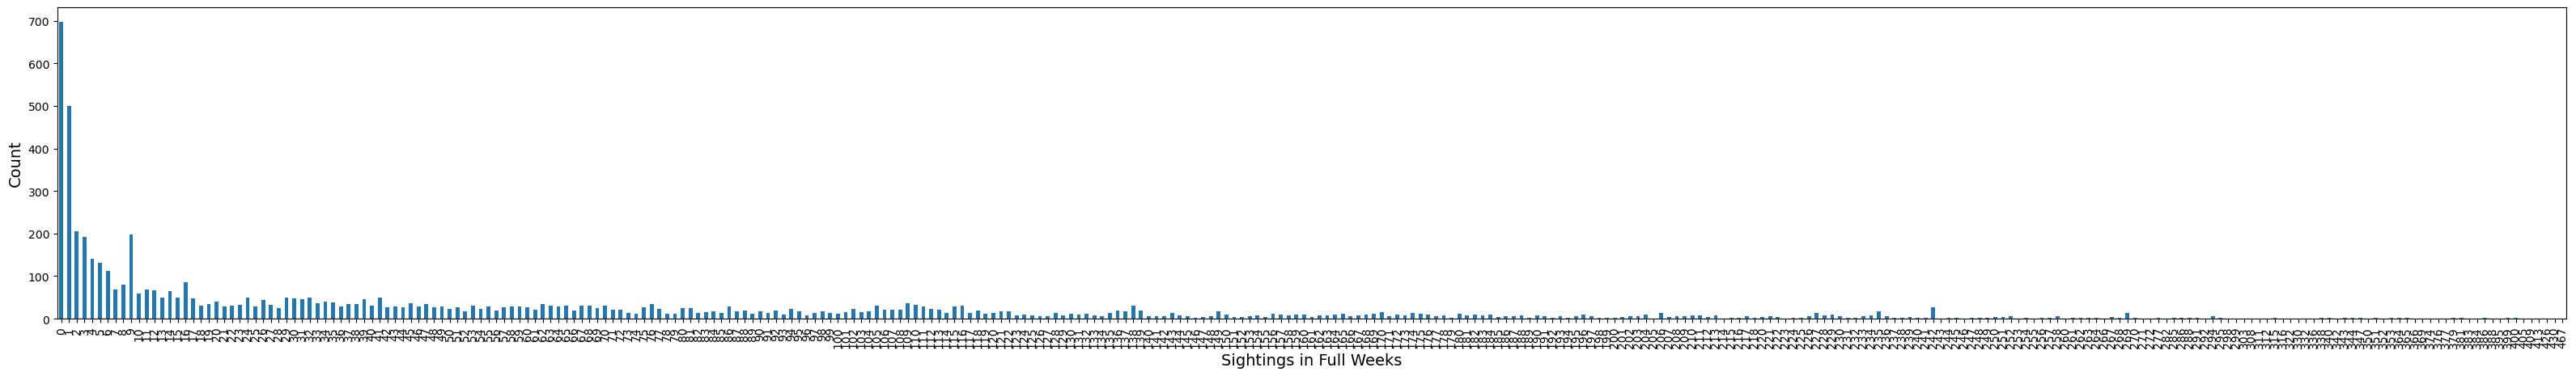

In [12]:
# Dispay as barplot
fig = plt.figure(figsize = (40, 5))
plt.xlabel("Sightings in Full Weeks", fontsize=14)
plt.ylabel("Count", fontsize=14)
timeline["SightingsTimelineWeeks"].value_counts().sort_index().plot.bar()

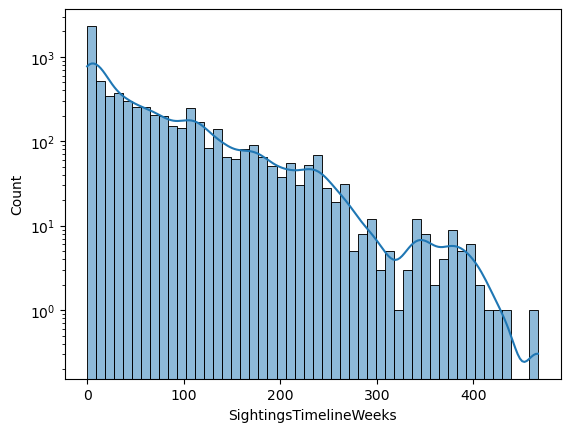

In [14]:
sns.histplot(timeline["SightingsTimelineWeeks"], kde=True, log=True)
plt.savefig("url_reg.svg",bbox_inches='tight')